In [1]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import torch.nn.functional as func

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [3]:


# Define transforms for data preprocessing
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 training and test datasets using PyTorch's DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)




Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = func.relu(self.conv1(x))
        x = func.max_pool2d(x, 2)
        x = func.relu(self.conv2(x))
        x = func.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network and use GPU
net = Net()
net.to(device)



Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Record the start time
start_time = time.time()

In [6]:
train_loss_list = []

# Training loop
for epoch in range(10):  # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels =  data[0].to(device), data[1].to(device)  # Move to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            train_loss_list.append(running_loss / 100)
            running_loss = 0.0

# Calculate total training time
end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move to GPU
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))


[1,   100] loss: 2.300
[1,   200] loss: 2.208
[1,   300] loss: 1.977
[2,   100] loss: 1.693
[2,   200] loss: 1.628
[2,   300] loss: 1.547
[3,   100] loss: 1.450
[3,   200] loss: 1.398
[3,   300] loss: 1.388
[4,   100] loss: 1.296
[4,   200] loss: 1.282
[4,   300] loss: 1.268
[5,   100] loss: 1.205
[5,   200] loss: 1.192
[5,   300] loss: 1.210
[6,   100] loss: 1.138
[6,   200] loss: 1.134
[6,   300] loss: 1.137
[7,   100] loss: 1.067
[7,   200] loss: 1.077
[7,   300] loss: 1.085
[8,   100] loss: 1.015
[8,   200] loss: 1.029
[8,   300] loss: 1.027
[9,   100] loss: 0.968
[9,   200] loss: 0.981
[9,   300] loss: 0.995
[10,   100] loss: 0.933
[10,   200] loss: 0.938
[10,   300] loss: 0.956
Total training time: 114.23 seconds
Accuracy of the network on the 10000 test images: 60.94 %


In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 82 %
Accuracy of  bird : 60 %
Accuracy of   cat : 50 %
Accuracy of  deer : 51 %
Accuracy of   dog : 27 %
Accuracy of  frog : 66 %
Accuracy of horse : 44 %
Accuracy of  ship : 62 %
Accuracy of truck : 56 %


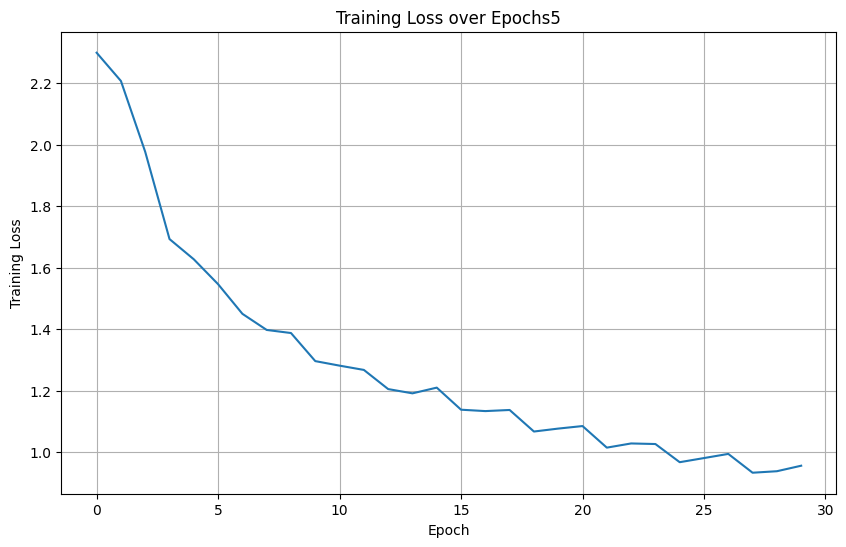

In [9]:
# Configure the plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs5')
plt.grid(True)
plt.show()